#### EE4708 - Data Analytics Lab - July-Nov 2020
##### Final Project : Team Cheems - Saarthak Marathe (ME17B162), Raj Jain (CH17B066)



#### Model can be downloaded from: https://drive.google.com/file/d/1H70uKE6mH0P-jibAWU1be_EftBEGtJhW/view?usp=sharing
Download the model and save it in the same folder as this notebook

In [25]:
#Importing relevant libraries
import numpy as np #For working with matrices
import pandas as pd #For dataframes
import matplotlib.pyplot as plt #For plotting
import os #For loading files
import os.path #For interacting with filepaths

from sklearn.model_selection import train_test_split #For splitting the data into training and validation sets
import glob #For loading files
from tqdm import tqdm #For visualising progress bar
import warnings #To ignore warnings
from skimage.feature import hog #For adding more features
warnings.filterwarnings('ignore')
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC


In [13]:
#Defining a function to take care of NaN values
import copy
def remove_nan(df):
    '''
    This function takes in an 28*28 image as input.
    The NaN values are imputated as the weighted average of adjacent pixel values.
    The weights are taken inversely proportional to the manhattan distance of the pixels upto max distance of 2.
    The weight given for manhattan distance 1 is 3/16, whereas weight given to pixels at manhattan distance of 2 are given a weight of 1/16.
    Returned is the image without NaN values.
    
    '''
    df= np.array(df)
    df1 = df.copy()    
    nan_arr = np.argwhere(np.isnan(df)) #Finding NaNs
    df1 = np.pad(df1,(1,1))
    ones_arr = np.ones((3,3))
    w_arr = [[1,3,1],[3,0,3],[1,3,1]] #weights
    df1 = np.array(df1)
    for i in range(len(nan_arr)):
   
        x=nan_arr[i][0]        
        y=nan_arr[i][1]

        arr = df1[x:x+3,y:y+3]
        arr=np.nan_to_num(arr)
       
        df[x][y] = np.sum(arr*w_arr)/16
   
    return df

In [31]:
def preprocess(df):    
    '''
    Brightens and blurs the image a bit, to smoothen the letters
    '''
    g1_arr = [[16,26,16],[26,41,26],[16,26,16]] #Gaussian blur filter
    for i in range(1,27):
        for j in range(1,27):
            x=i       
            y=j      
            arr = df[x-1:x+2,y-1:y+2] #Defining a 3x3 closed neighbourhood
            df[x][y] = np.sum(arr*g1_arr)/(209) #Applying gaussian blur
       
            #Brightening the image
            if df[x][y]>=170 and df[x][y]<220:
                df[x][y]=df[x][y]+35
            if df[x][y]>=220 and df[x][y]<230:
                df[x][y]=df[x][y]+25
            if df[x][y]>=230 and df[x][y]<240:
                df[x][y]=df[x][y]+15
            if df[x][y]>=240 and df[x][y]<245:
                df[x][y]=df[x][y]+10   
    df = df/255
    return df

In [14]:
#Loading the data and removing NaNs
np_array_list = []
labels = []
for i in tqdm(range(10)):
    path = "Training Dataset/character_"+str(i)
    allFiles = glob.glob(os.path.join(path,"*.csv"))
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=None)
        df = remove_nan(df)
        A = np.asarray(df).reshape(-1)
        labels.append(i)
        np_array_list.append(A)

comb_np_array = np.vstack(np_array_list)
big_frame = pd.DataFrame(comb_np_array)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.25s/it]


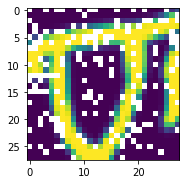

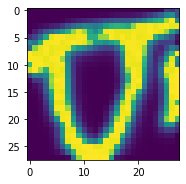

In [15]:
#Visualising images and pre and post Nan imputation

df1 = pd.read_csv("Training Dataset/character_2/5.csv", index_col=None, header=None)

plt.subplot(121),plt.imshow(df1)

plt.show()

df1 = remove_nan(df1)
df1 = preprocess(df1)
plt.subplot(122),plt.imshow(df1)

plt.show()

In [20]:
def feature_add(big_frame):
    '''
    Preprocessing the data and adding engineered features based on HOG (edge detection) and pooling filters 
    '''
    big_frame = np.array(big_frame)
    big_frame1 = np.array([np.zeros((1884,))]*len(big_frame))
    for i in range(len(big_frame)):
        df = (big_frame[i][:])
        df = df.reshape(28,28)
        df = preprocess(df) #Preprocessing data
      
        avg_pool=[]
        df1 = df.copy()
        df1 = np.pad(df1,(1,1))
        
        for j in range(1,df1.shape[0]-1,3):
            for k in range(1,df1.shape[1]-1,3):
                arr = df1[j-1:j+2,k-1:k+2]
                avg_pool.append(np.sum(arr)/9)
                
        avg_pool = np.array(avg_pool).reshape(10,10)
        df = df.reshape(-1)
        df_hog = hog(df1, orientations = 10, pixels_per_cell=(3,3), cells_per_block=(1,1), multichannel=False)
        df = np.concatenate((df,df_hog))
        df = np.concatenate((df,avg_pool.ravel()))

        big_frame1[i] = df
    return big_frame1

In [19]:
#Adding features
big_frame1 = feature_add(big_frame)

In [475]:
print('Shape of features matrix:',big_frame1.shape,'\nShape of labels:',np.array(labels).shape)

Shape of features matrix: (10000, 1884) 
Shape of labels: (10000,)


In [476]:
X_train,X_val,y_train,y_val = train_test_split(big_frame1,np.array(labels),test_size=0.25,shuffle=True,random_state=42)
print('X_train shape:',X_train.shape,' || y_train shape:',y_train.shape)
print('X_val shape:',X_val.shape,' || y_val shape:',y_val.shape)

X_train shape: (7500, 1884)  || y_train shape: (7500,)
X_val shape: (2500, 1884)  || y_val shape: (2500,)


In [477]:
clf = SVC(kernel = 'rbf', C=2500) #SVM with radial basis function
clf = clf.fit(big_frame1,np.array(labels)) #Fitting the data, using complete training set
y_pred = clf.predict(X_val) #Predicting on the validation set


#Print the Confusion Matrix
print('Confusion Matrix:\n',confusion_matrix(y_val,y_pred))

#Print the F1 score
print('\nF1 Score:',f1_score(y_val,y_pred,average='macro'))

#Print accuracy
print(accuracy_score(y_val, y_pred))

Confusion Matrix:
 [[257   0   0   0   0   0   0   0   0   0]
 [  0 256   0   0   0   0   0   0   0   0]
 [  0   0 234   0   0   0   0   0   0   0]
 [  0   0   0 251   0   0   0   0   0   0]
 [  0   0   0   0 274   0   0   0   0   0]
 [  0   0   0   0   0 238   0   0   0   0]
 [  0   0   0   0   0   0 252   0   0   0]
 [  0   0   0   0   0   0   0 257   0   0]
 [  0   0   0   0   0   0   0   0 266   0]
 [  0   0   0   0   0   0   0   0   0 215]]

F1 Score: 1.0
1.0


# Test cases

In [21]:
#Loading the test dataset
test_data = np.loadtxt('public_test.csv',delimiter=',').T


# Fixing test data
# The given test dataset has its images reshaped to a one dimensional vector column wise, 
# but our model takes in values as row-wise reshaped arrays.
# Hence, fixing the test dataset to match the feature order of the model.
# later we apply the feature add function to it.


new_test = test_data.reshape(1000,28,28)
for i in range(len(new_test)):
    new_test[i] = new_test[i].T
new_test = new_test.reshape(1000,-1)
new_test1 = feature_add(new_test)

In [479]:
#Predicting on the test set
y_test_pred = clf.predict(new_test1)

In [487]:
#Saving the predicted values
sample_sub = pd.read_csv('Sample_Submission.csv')
d = {'Id':sample_sub['Id'],'Expected': y_test_pred}
dtf = pd.DataFrame(data=d)
dtf.to_csv('submission3.csv',index=False)

#### Model can be downloaded from: https://drive.google.com/file/d/1H70uKE6mH0P-jibAWU1be_EftBEGtJhW/view?usp=sharing
Download the model and save it in the same folder as this notebook

In [45]:
#Defining a function to predict private dataset as required

def predict_private_dataset(test_path='private_test.csv',model_path='cheems_model.pkl'):
    '''
    INPUT:  path to private test dataset(string)
            
            Path to the saved model (string)
            
    OUTPUT: predicted labels (nsamples x 1)
    Please be patient it takes around a minute to predict :)
    '''
    test_data = np.loadtxt(test_path,delimiter=',').T


    new_test = test_data.reshape(1000,28,28)
    for i in range(len(new_test)):
        new_test[i] = new_test[i].T
    new_test = new_test.reshape(1000,-1)
    new_test1 = feature_add(new_test)
    
    #Loading the model
    with open(model_path, 'rb') as file:  
        Model = pickle.load(file)
    predicted_class = Model.predict(new_test1)
    
    return predicted_class

In [42]:
predicted_class = predict_private_dataset()